## Unzip Dataset

In [ ]:
!unzip /content/train_all.zip -d /content/dataset/

In [ ]:
!unzip /content/test_all.zip -d /content/final_test/

In [ ]:
!unzip /content/ck-aio-hutech.zip -d /content/final_test1/

## Setup train test data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import random
import torch.optim as optim
from tqdm import tqdm
import numpy as np
# from MedMamba import VSSM as medmamba # import model

In [ ]:
SEED = 25
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [ ]:
from sklearn.model_selection import train_test_split

data_dir = '/content/dataset'
classes = os.listdir(data_dir)
classes.sort()
print(classes)

['tai mèo', 'tuyết khô', 'đông cô']


In [ ]:
def read_data(path):
  train_x, train_y = [],[]
  for labels in os.listdir(path):
    img_dir = os.path.join(path,labels)
    for data in os.listdir(img_dir):
      train_x.append(os.path.join(img_dir,data))
      train_y.append(labels)

  return train_x,train_y

In [ ]:
dir = '/content/dataset'
x,y = read_data(dir)

In [ ]:
train_x,test_x, train_y,test_y = train_test_split(x,y, test_size=0.1, random_state=42)

In [ ]:
labels = {
    'đông cô':0,
    'tai mèo': 1,
    'tuyết khô': 2
}

In [ ]:
train_y = [labels[label] for label in train_y]
test_y = [labels[label] for label in test_y]

In [ ]:
from collections import Counter
label_counts = Counter(train_y)

In [ ]:
label_counts

Counter({0: 281, 1: 282, 2: 287})

##Build class dataset

In [ ]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

data_transform = transforms.Compose([
    transforms.Resize((96, 96), interpolation=InterpolationMode.BICUBIC),  # Resize nhẹ để giữ chi tiết
    transforms.RandomResizedCrop(96, scale=(0.85, 1.0), ratio=(0.9, 1.1)),  # Giảm bias từ background
    transforms.RandomHorizontalFlip(p=0.5),                                 # Flip trái/phải
    transforms.RandomRotation(degrees=30),                                  # Xoay nhẹ để tăng biến thể
    transforms.ColorJitter(                                                 # Làm đa dạng màu sắc và độ sáng
        brightness=0.3,
        contrast=0.1,
        saturation=0.2,
        hue=0.04
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),              # Biến hình nhẹ mô phỏng góc chụp
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [ ]:
class OAI_dataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long) # Change dtype to torch.long
        return image, label

Load data kết quả btc lên ( load tập test)

In [ ]:
import os

def read_test_data(new_path):
  final = []
  for data in os.listdir(new_path):
    # Check if it's a directory and if it's the one we want to exclude
    if os.path.isdir(os.path.join(new_path, data)) and data == '.ipynb_checkpoints':
      continue  # Skip this directory

    list_img = os.path.join(new_path, data)
    final.append(list_img)
  return final



In [ ]:
final_result = read_test_data('/content/final_test1/oai_data/test')

In [ ]:
train_dataset = OAI_dataset(train_x, train_y, transform=data_transform)
test_dataset = OAI_dataset(test_x, test_y, transform=data_transform)

In [ ]:
# Tạo DataLoader với num_workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##Model

In [ ]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
import torch.nn as nn

# 1. Load pretrained model
model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights)

# # 2. Freeze tất cả layer trước
# for param in model.parameters():
#     param.requires_grad = False




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:03<00:00, 148MB/s]


In [ ]:
from torchvision.models import convnext_large,ConvNeXt_Large_Weights
import torch.nn as nn

# 1. Load pretrained model
model2 = convnext_large(weights=ConvNeXt_Large_Weights)

# # 2. Freeze tất cả layer trước
# for param in model2.parameters():
#     param.requires_grad = False




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:08<00:00, 90.5MB/s]


In [ ]:
!git clone https://github.com/Semillero-Lun-Universidad-de-Ibague/EfficientNetB1Kan-.git

Cloning into 'EfficientNetB1Kan-'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 329 (delta 170), reused 276 (delta 117), pack-reused 0 (from 0)
Receiving objects: 100% (329/329), 3.86 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (170/170), done.


In [ ]:
%cd /content/EfficientNetB1Kan-

/content/EfficientNetB1Kan-


In [ ]:
from kcn import KANLinear

In [ ]:
import torch
import torch.nn as nn
from kcn import KANLinear  # pip install kcn


# Define ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, num_classes):
        super().__init__()
        self.model1 = model1.features
        self.model2 = model2.features

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten_dim = 1280 + 1536  # EfficientNetV2-L + ConvNeXt-Large

        # Replace MLP with KAN layers
        self.kan_layers = nn.Sequential(
            KANLinear(self.flatten_dim, 512),
            KANLinear(512, num_classes)
        )

    def forward(self, x):
        f1 = self.model1(x)
          f1 = self.pool(f1)
          f1 = torch.flatten(f1, 1)

        f2 = self.model2(x)
        f2 = self.pool(f2)
        f2 = torch.flatten(f2, 1)

        concat = torch.cat([f1, f2], dim=1)
        out = self.kan_layers(concat)

        return out




In [ ]:
combine_model = EnsembleModel( model, model2,num_classes=4).to(device)
#

##Train


In [ ]:
for name, param in combine_model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


In [ ]:
import torch.optim as optim

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, combine_model.parameters()),
    lr=0.0001,
    weight_decay=1e-5  # hoặc 5e-5 nếu muốn nhẹ hơn
)
criterion = nn.CrossEntropyLoss()
reduce_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',               # vì monitor='val_loss'
    factor=0.5,
    patience=3,

)




In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=100):  # Mặc định num_epochs là 100
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_f1s, val_precisions, val_recalls = [], [], []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        scheduler.step(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_accuracy:.2f}% - '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_accuracy:.2f}% - '
              f'F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')

        # Save model at every 20 epochs
        if (epoch + 1) % 20 == 0:
            filename = f'/content/kanModel_epoch{epoch + 1}.pth'
            torch.save(model.state_dict(), filename)
            print(f"💾 Model saved at epoch {epoch + 1} -> {filename}")

    return train_losses, val_losses, train_accuracies, val_accuracies, val_f1s, val_precisions, val_recalls


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies, val_f1s, val_precisions, val_recalls = train_model(
    model=combine_model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=reduce_lr_scheduler,
    num_epochs=100
)

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Load lại model để test

In [ ]:
import torch
import torch.nn as nn
from kcn import KANLinear  # pip install kcn


# Define ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, num_classes):
        super().__init__()
        self.model1 = model1.features
        self.model2 = model2.features

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten_dim = 1280 + 1536  # EfficientNetV2-L + ConvNeXt-Large

        # Replace MLP with KAN layers
        self.kan_layers = nn.Sequential(
            KANLinear(self.flatten_dim, 512),
            KANLinear(512, num_classes)
        )

    def forward(self, x):
        f1 = self.model1(x)
        f1 = self.pool(f1)
        f1 = torch.flatten(f1, 1)

        f2 = self.model2(x)
        f2 = self.pool(f2)
        f2 = torch.flatten(f2, 1)

        concat = torch.cat([f1, f2], dim=1)
        out = self.kan_layers(concat)

        return out




In [ ]:
combine_model = EnsembleModel(model,model2, num_classes=4).to(device)
#

In [ ]:
# In ipython-input-55-9738d0f7fd7a
state_dict = torch.load('/content/drive/MyDrive/model_OAI/final_model.pth')
# Load the state dictionary without assigning the result back to ve_model
combine_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

data_transform1 = transforms.Compose([
    transforms.Resize((96, 96), interpolation=InterpolationMode.BICUBIC),  # Resize nhẹ để giữ chi tiết
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


## Test

In [ ]:
combine_model.eval()
correct = 0
total = 0
y_predict=[]

with torch.no_grad():
    for images in final_result:
        # Move images and labels to the same device as the device
            # Check if it's a directory before listing its contents
        image = Image.open(images).convert('RGB')
        image_path = data_transform(image).unsqueeze(0).to(device)
        outputs = combine_model(image_path)
        _, predicted = torch.max(outputs.data, 1)
        img_id = images.split('/')[-1].split('.')[0]
        y_predict.append([img_id,predicted.item()])


In [ ]:
y_predict

[['1745420429107_2e92b8aa', 0],
 ['1745420429187_0f1d75e6', 2],
 ['1745420431357_bb95c021', 2],
 ['1745420431606_402154ec', 2],
 ['1745420430519_c6c365cc', 1],
 ['1745420430037_69e824d0', 1],
 ['1745420431086_f144cba9', 1],
 ['1745420430597_4be239c0', 0],
 ['1745420434343_18f3bce5', 0],
 ['1745420433940_a8f825c2', 1],
 ['1745420429817_3a8f51e3', 0],
 ['1745420434910_e4e9f52b', 2],
 ['1745420432921_a602a6b1', 0],
 ['1745420428883_b32827f9', 1],
 ['1745420434619_b6806896', 1],
 ['1745420435265_78b7d746', 2],
 ['1745420433860_dc2a4e8f', 2],
 ['1745420432874_0b1f794b', 0],
 ['1745420429011_4dd1bf70', 1],
 ['1745420434527_3d72cbe3', 2],
 ['1745420432544_d0df4159', 2],
 ['1745420432984_8266e2d0', 1],
 ['1745420435568_72999e6c', 1],
 ['1745420431591_d9e54ba4', 2],
 ['1745420429659_2c64511b', 2],
 ['1745420430828_0473f139', 0],
 ['1745420430407_e6ce34e5', 1],
 ['1745420435375_5d6a4da1', 0],
 ['1745420435328_4885b61a', 2],
 ['1745420431734_914b28b2', 2],
 ['1745420431782_24ddff13', 1],
 ['17454

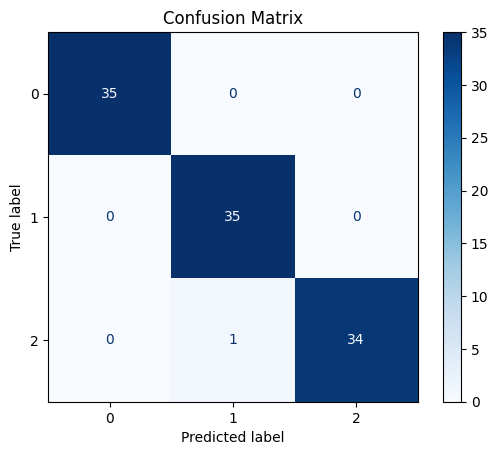

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lấy danh sách nhãn thật và nhãn dự đoán
y_true = merged_df['label_1']
y_pred = merged_df['label_2']

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
